# Grover's Algorithm
Grover's algorithm is a search algorithm for finding the unique input to a black box function which produces a particular output value using $O(\sqrt{N})$ evaluations of the function. For our example, we will be attempting to find the value $x$ which when input into our function (e.g. $f(x)$) evaluates to $1$.

The search algorithm uses an "Oracle" i.e. a set of gates which "find" the result.

In [40]:
from random import choice, shuffle
from itertools import product

### Classical Problem
We can easily define the problem of the function classically. For our example, we will define a function which takes in an integer defining the length of possible bit configurations to search.

In [41]:
def black_box(ans):
    return lambda x: x == ans

def classic_problem(n):
    possible_values = [''.join(val) for val in list(product(['0', '1'], repeat=n))]
    correct_value = choice(possible_values) # Designate an arbitrary value as the "correct" answer

    return black_box(correct_value)

### Classical Solution
Given the classic problem, we can then define a "solver" which 

In [42]:
def classic_solver(n):
    is_solution = classic_problem(n)
    possible_values = [''.join(val) for val in list(product(['0', '1'], repeat=n))]
    shuffle(possible_values) # Shuffle the answers to check to randomize answer with results
    
    for i, val in enumerate(possible_values):
        if is_solution(val):
            return val, i + 1

In [43]:
answer, attempts = classic_solver(3)
print(f"Answer: {answer}\tAttempts: {attempts}")

Answer: 000	Attempts: 8


### Quantum Solution
We can now begin to define the quantum mechanical solution. For this solution, we will need $n$ qubits for the $2^n$ possible states as well as an additional ancillary qubit. To fully implement Grover's search algorithm, we will need a few helper methods for generating circuitry. Namely, we will need functions to do the following:
- Generate the oracle
- Apply the Grover Diffusion Operator

In [44]:
from qiskit import *
import math

#### Setup
We define a setup circuit which is used to create a superposition for a given qubit. We define the operation which will act on one qubit, then later assign the instruction to the whole set of qubits at the beginning of the completed circuit.

In [45]:
def setup_circ():
    setup = QuantumCircuit(1, name='setup')
    setup.h(0)
            
    return setup
            
setup_inst = setup_circ().to_instruction()

#### Oracle
To generate the oracle (i.e. the black box function to evaluate), we create a function which takes an answer as an input to generate the circuit. To find the answer with high probability, we only need to evaluate the circuit $FILL OUT$ times as opposed to $n$ times.

For the oracle to select a value, we must construct a circuit which takes our state $\mid\phi\rangle=\mid\phi_{0..00}\rangle + \mid\phi_{0..01}\rangle + ... + \mid\phi_i\rangle + ... \mid\phi_{1..11}\rangle$ and converts the state where $i$ is our selected value to $-\mid\phi_i\rangle$ and keeps the other states unchanged.

In [46]:
def black_box_circ(ans):
    n = len(ans)
    regs = QuantumRegister(n)
    oracle_circ = QuantumCircuit(regs, name='oracle')
    
    # Multi-controlled Z operation with all but the last qubit as control, and the last qubit as target
    cz_op = lambda: oracle_circ.mcrz(math.pi, regs[0:n-1], regs[n - 1])

    # Find all registers to encode as a '0' in the oracle circuit
    encode_0 = [regs[i] for (i, val) in enumerate(reversed(ans)) if val == '0']
    if encode_0:
        oracle_circ.x(encode_0)
        cz_op()
        oracle_circ.x(encode_0)
    else:
        cz_op()

    return oracle_circ
    
black_box_inst = lambda x: black_box_circ(x).to_instruction()

#### Grover Diffusion (Amplitude Amplification) Operator
The Grover diffusion operator takes the value selected by the above Oracle (e.g. 

In [47]:
def grover_diffuse_op_circ(n):
    diffuse_op_regs = QuantumRegister(n)
    diffuse_op_circ = QuantumCircuit(diffuse_op_regs, name='diffuse_op')

    diffuse_op_circ.h(diffuse_op_regs)
    diffuse_op_circ.x(diffuse_op_regs)
    diffuse_op_circ.h(diffuse_op_regs[n-1])
    diffuse_op_circ.mcx(diffuse_op_regs[0:n-1], diffuse_op_regs[n-1])
    diffuse_op_circ.h(diffuse_op_regs[n-1])
    diffuse_op_circ.x(diffuse_op_regs)
    diffuse_op_circ.h(diffuse_op_regs)
    
    return diffuse_op_circ

# def grover_diffuse_op_circ_alt(n):
    

grover_diffuse_op_inst = lambda x: grover_diffuse_op_circ(x).to_instruction()

In [48]:
def grover_search_circ(ans, iterations=0):
    n = len(ans)
    search_regs = QuantumRegister(n, name='q')
    cl_regs = ClassicalRegister(n, name='c')
    grover_circ = QuantumCircuit(search_regs, cl_regs, name='grover_search')
    
    m_black_box_circ = black_box_inst(ans)
    m_grover_diffuse_operator = grover_diffuse_op_inst(n)

    # Apply the even superposition across all qubits
    for i in range(n):
        grover_circ.append(setup_inst, [i])
    grover_circ.barrier()

    # A bit of math to handle low numbers or define the number of iterations as sqrt(n)
    if iterations is 0:
        iterations = round(math.sqrt(math.pow(2, n)) * .25 * math.pi)
        
    # For our iteration count, we run through the black box (oracle) gate as well as the diffusion operator
    for i in range(iterations):
        grover_circ.append(m_black_box_circ, search_regs)
        grover_circ.barrier()

        grover_circ.append(m_grover_diffuse_operator, search_regs)
        grover_circ.barrier()

    grover_circ.measure(search_regs, cl_regs)

    return grover_circ

In [49]:
backend_sim = Aer.get_backend('qasm_simulator')

In [50]:
def test_grover_search_circ():
    shots = 2048
    size_to_test = 5
    all_values = [''.join(val) for val in list(product(['0', '1'], repeat=size_to_test))]
    
    for val in all_values:
        test_circ = grover_search_circ(val)
        job_sim = execute(test_circ, backend_sim, shots=shots)
        result = job_sim.result()
        counts = result.get_counts(test_circ)
        
        value_fidelity = counts.get(val)
        
        assert value_fidelity is not None, "Value not present in result of executions."
        assert value_fidelity > 0.95, f"Fidelity for value {val} is {value_fidelity} which is below desired 95% fidelity."
        
test_grover_search_circ()

In [51]:
def graph_grover_search_circ():
    shots = 1024
    sizes_to_test = range(2, 6)
    res = []

    for n in sizes_to_test:
        all_values = [''.join(val) for val in list(product(['0', '1'], repeat=n))]        

        for val in all_values:
            for iteration in range(1, n):
                test_circ = grover_search_circ(val, iterations=iteration)
                job_sim = execute(test_circ, backend_sim, shots=shots)
                result = job_sim.result()
                counts = result.get_counts(test_circ)
                
                res += [(val, iteration, counts[val], counts[val]/shots)]
    
    return res

In [52]:
results = graph_grover_search_circ()
for value, iteration, correct_attempts, success_rate in results:
    print(f"{value}\t{iteration}\t{correct_attempts}\t{success_rate}")

00	1	1024	1.0
01	1	1024	1.0
10	1	1024	1.0
11	1	1024	1.0
000	1	785	0.7666015625
000	2	966	0.943359375
001	1	783	0.7646484375
001	2	963	0.9404296875
010	1	812	0.79296875
010	2	967	0.9443359375
011	1	803	0.7841796875
011	2	956	0.93359375
100	1	786	0.767578125
100	2	969	0.9462890625
101	1	825	0.8056640625
101	2	974	0.951171875
110	1	778	0.759765625
110	2	969	0.9462890625
111	1	800	0.78125
111	2	969	0.9462890625
0000	1	480	0.46875
0000	2	927	0.9052734375
0000	3	982	0.958984375
0001	1	480	0.46875
0001	2	945	0.9228515625
0001	3	988	0.96484375
0010	1	483	0.4716796875
0010	2	936	0.9140625
0010	3	987	0.9638671875
0011	1	497	0.4853515625
0011	2	923	0.9013671875
0011	3	990	0.966796875
0100	1	449	0.4384765625
0100	2	927	0.9052734375
0100	3	988	0.96484375
0101	1	477	0.4658203125
0101	2	931	0.9091796875
0101	3	988	0.96484375
0110	1	470	0.458984375
0110	2	930	0.908203125
0110	3	979	0.9560546875
0111	1	511	0.4990234375
0111	2	946	0.923828125
0111	3	991	0.9677734375
1000	1	494	0.482421875
1000	2	926	0.9

In [53]:
grover_search_circ('00110').draw()

┌───────┐ ░ ┌─────────┐ ░ ┌─────────────┐ ░ ┌─────────┐ ░ ┌─────────────┐»
q_0: ┤ setup ├─░─┤0        ├─░─┤0            ├─░─┤0        ├─░─┤0            ├»
     ├───────┤ ░ │         │ ░ │             │ ░ │         │ ░ │             │»
q_1: ┤ setup ├─░─┤1        ├─░─┤1            ├─░─┤1        ├─░─┤1            ├»
     ├───────┤ ░ │         │ ░ │             │ ░ │         │ ░ │             │»
q_2: ┤ setup ├─░─┤2 oracle ├─░─┤2 diffuse_op ├─░─┤2 oracle ├─░─┤2 diffuse_op ├»
     ├───────┤ ░ │         │ ░ │             │ ░ │         │ ░ │             │»
q_3: ┤ setup ├─░─┤3        ├─░─┤3            ├─░─┤3        ├─░─┤3            ├»
     ├───────┤ ░ │         │ ░ │             │ ░ │         │ ░ │             │»
q_4: ┤ setup ├─░─┤4        ├─░─┤4            ├─░─┤4        ├─░─┤4            ├»
     └───────┘ ░ └─────────┘ ░ └─────────────┘ ░ └─────────┘ ░ └─────────────┘»
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_3: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_4: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ░ ┌─────────┐ ░ ┌─────────────┐ ░ ┌─────────┐ ░ ┌─────────────┐ ░ ┌─┐   »
«q_0: ─░─┤0        ├─░─┤0            ├─░─┤0        ├─░─┤0            ├─░─┤M├───»
«      ░ │         │ ░ │             │ ░ │         │ ░ │             │ ░ └╥┘┌─┐»
«q_1: ─░─┤1        ├─░─┤1            ├─░─┤1        ├─░─┤1            ├─░──╫─┤M├»
«      ░ │         │ ░ │             │ ░ │         │ ░ │             │ ░  ║ └╥┘»
«q_2: ─░─┤2 oracle ├─░─┤2 diffuse_op ├─░─┤2 oracle ├─░─┤2 diffuse_op ├─░──╫──╫─»
«      ░ │         │ ░ │             │ ░ │         │ ░ │             │ ░  ║  ║ »
«q_3: ─░─┤3        ├─░─┤3            ├─░─┤3        ├─░─┤3            ├─░──╫──╫─»
«      ░ │         │ ░ │             │ ░ │         │ ░ │             │ ░  ║  ║ »
«q_4: ─░─┤4        ├─░─┤4            ├─░─┤4        ├─░─┤4            ├─░──╫──╫─»
«      ░ └─────────┘ ░ └─────────────┘ ░ └─────────┘ ░ └─────────────┘ ░  ║  ║ »
«c_0: ════════════════════════════════════════════════════════════════════╩══╬═»
«                                                                            ║ »
«c_1: ═══════════════════════════════════════════════════════════════════════╩═»
«                                                                              »
«c_2: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_3: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_4: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«              
«q_0: ─────────
«              
«q_1: ─────────
«     ┌─┐      
«q_2: ┤M├──────
«     └╥┘┌─┐   
«q_3: ─╫─┤M├───
«      ║ └╥┘┌─┐
«q_4: ─╫──╫─┤M├
«      ║  ║ └╥┘
«c_0: ═╬══╬══╬═
«      ║  ║  ║ 
«c_1: ═╬══╬══╬═
«      ║  ║  ║ 
«c_2: ═╩══╬══╬═
«         ║  ║ 
«c_3: ════╩══╬═
«            ║ 
«c_4: ═══════╩═
«

11011	1024	1.0


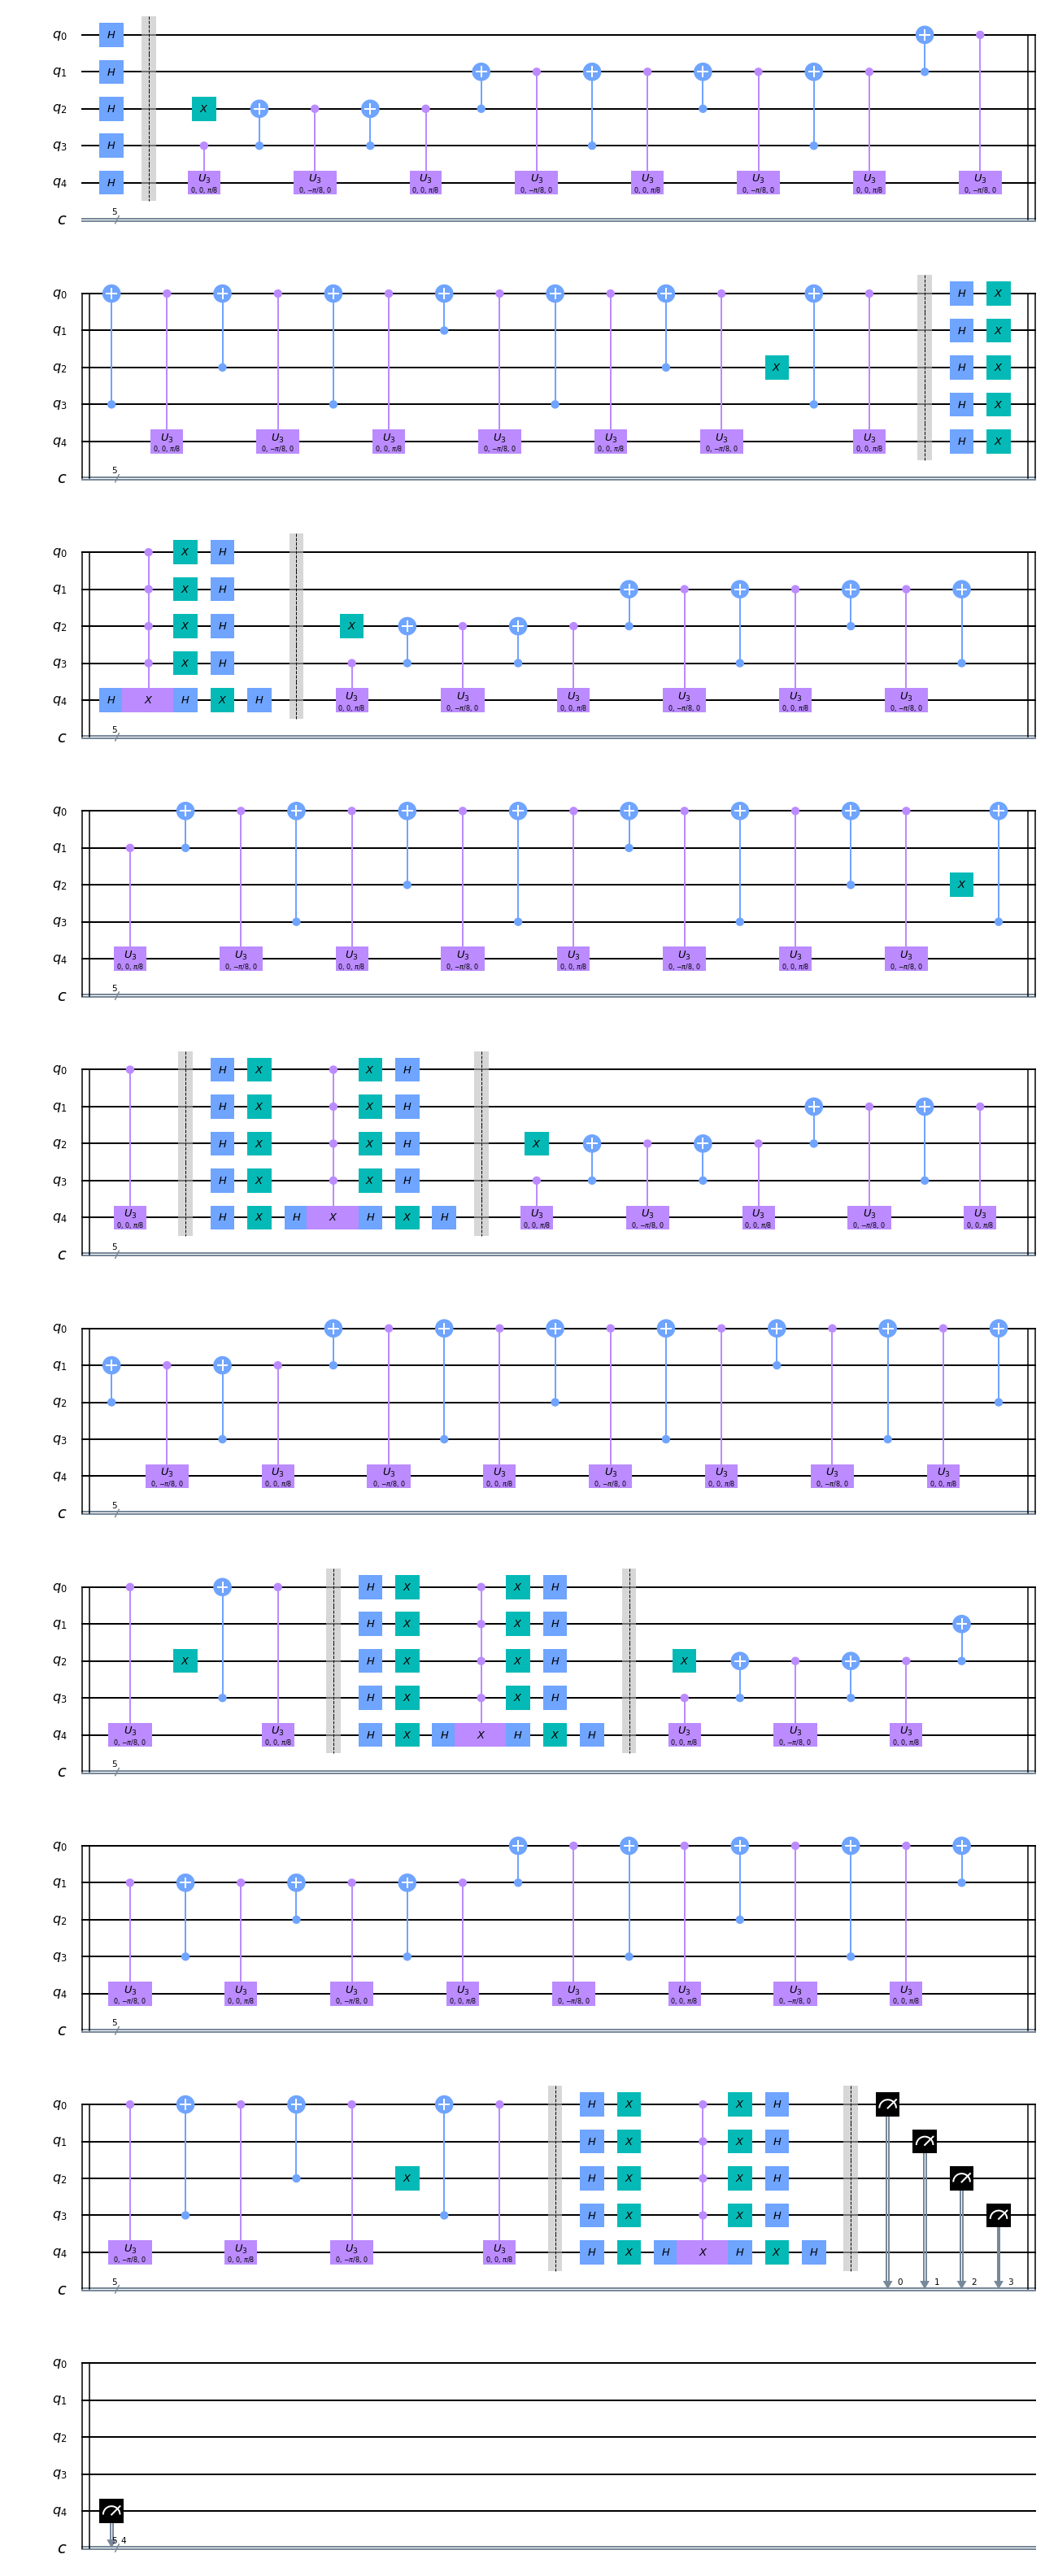

In [54]:
val = '11011'
shots = 1024
test_circ = grover_search_circ(val)

job_sim = execute(test_circ, backend_sim, shots=shots)

result = job_sim.result()
counts = result.get_counts(test_circ)

[print(f"{k}\t{v}\t{v/shots}") for (k, v) in counts.items()]

test_circ.decompose().draw('mpl')

### Alternative Constructions
There are alternative ways to construct this circuit, but require more operations or ancillary qubits. Specific implementations may be preferable over other configurations and are certainly helpful in the learning process.

In [55]:
def black_box_circ_alt(ans):
    oracle_regs = QuantumRegister(len(ans) + 1)
    oracle_circ = QuantumCircuit(oracle_regs, name='oracle')

    encode_0 = [oracle_regs[i] for (i, val) in enumerate(reversed(ans)) if val == '0']
    
    cx_op = lambda: oracle_circ.mcx(oracle_regs[0:n-1], n-1)

    if encode_0:
        oracle_circ.x(encode_0)
        cx_op()
        oracle_circ.x(encode_0)
    else:
        cx_op()
        
    return oracle_circ